In [3]:
import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"using PyTorch version: {torch.__version__}, Device: {device}")

using PyTorch version: 2.3.0+cu118, Device: cuda


In [5]:
import os
root_dir = r"/media/ramius/M2Data/DeepLearning/Datasets/man_vs_woman"
print(os.listdir(root_dir)  )

['test', 'train']


In [6]:
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')

In [7]:
# 데이터 전처리 및 변환
train_config = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),])        # 이미지를 텐서로 변환
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  #정규화 과정

test_config = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),])
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


In [8]:
train_dataset = datasets.ImageFolder(train_dir, train_config)
test_dataset = datasets.ImageFolder(test_dir, test_config)

In [9]:
train_dataset_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset_loader = DataLoader(test_dataset, batch_size= 32, shuffle=False)

In [10]:
images , labels = next(iter(train_dataset_loader))

print(images.shape, type(images), labels.shape, type(labels))

torch.Size([32, 3, 224, 224]) <class 'torch.Tensor'> torch.Size([32]) <class 'torch.Tensor'>


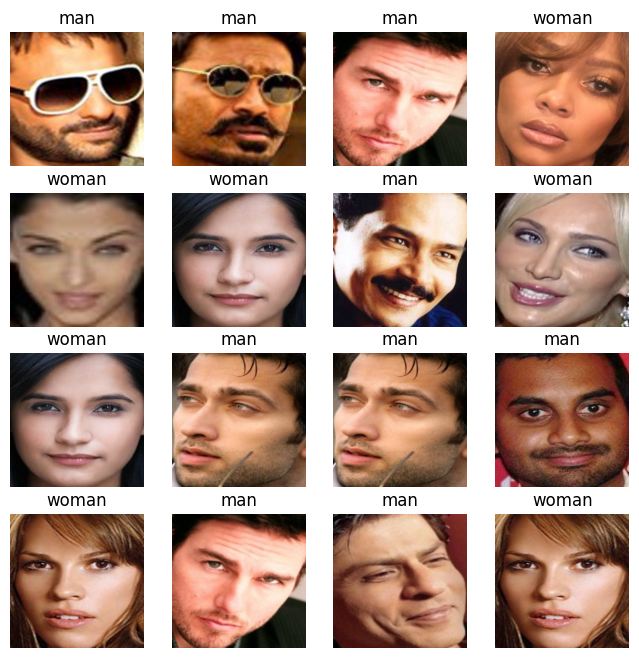

In [11]:
import matplotlib.pyplot as plt

# ImageFolder의 속성 값인 class_to_idx를 할당

labels_map = { v:k  for k, v in train_dataset.class_to_idx.items() }

figure = plt.figure(figsize=(8, 8))

cols, rows = 4, 4

# 이미지 출력

for i in range(1,  cols*rows+1):

    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()

    figure.add_subplot(rows, cols, i)

    plt.title(labels_map[label])
    plt.axis("off")

    # 본래 이미지의 shape은 (3, 224, 224) 인데,
    # 이를 imshow() 함수로 이미지 시각화 하기 위하여 (224, 224, 3)으로 shape 변경을 한 후 시각화
    plt.imshow(torch.permute(img, (1, 2, 0)))

plt.show()

In [12]:

# (3, 224, 224) 배열을 (224, 224, 3) 배열로 바꾸고
images = images.permute(0, 2, 3, 1)

# torch tensor 를 numpy() 로 바꾸고
images = images.numpy()
labels = labels.numpy()

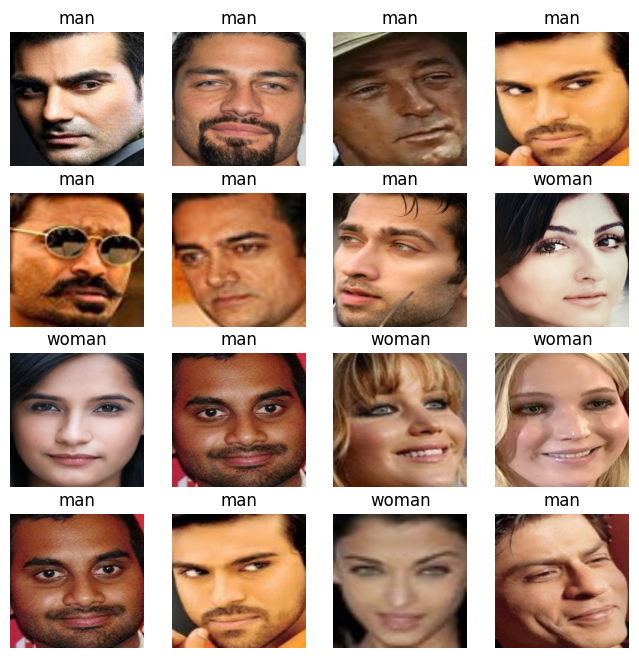

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import random

label_map = {
    0 : 'man',
    1 : 'woman'
}

random_idx = np.random.randint(0, len(images), size=16)
plt.figure(figsize=(8, 8))
for i, idx in enumerate(random_idx):
    img = images[idx]
    label_idx = labels[idx]
    label = label_map[label_idx]
    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.show()

In [14]:
# deep CNN 을 위한 모델을 만들고 
# 300 을 5번 Dropout 으로 모양을 줄이므로
# 300 -> 150 -> 75 -> 37 ->18 -> 9 
# 최종 2개를 분류하여야 하므로 (128, 2)

class MyCNNModel(nn.Module):

    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(7 * 7 * 256, 128)
        self.fc2 = nn.Linear(128, 2)

        self.dropout25 = nn.Dropout(p=0.25)
        self.dropout50 = nn.Dropout(p=0.5)

    def forward(self, data):

        data = self.conv1(data)
        data = torch.relu(data)
        data = self.conv2(data)
        data = torch.relu(data)
        data = self.pooling(data)
        data = self.dropout25(data)

        data = self.conv3(data)
        data = torch.relu(data)
        data = self.conv4(data)
        data = torch.relu(data)
        data = self.pooling(data)
        data = self.dropout25(data)

        data = self.conv5(data)
        data = torch.relu(data)
        data = self.pooling(data)
        data = self.dropout25(data)

        data = self.conv6(data)
        data = torch.relu(data)
        data = self.pooling(data)
        data = self.dropout25(data)

        data = self.conv7(data)
        data = torch.relu(data)
        data = self.pooling(data)
        data = self.dropout25(data)

        data = data.view(-1, 7 * 7 * 256)

        data = self.fc1(data)
        data = torch.relu(data)
        data = self.dropout50(data)

        logits = self.fc2(data)

        return logits

model = MyCNNModel().to(device)
print(model)

MyCNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (dropout25): Dropout(p=0.25, inplace=False)
  (dropout50): Dropout(p=0.5, inplace=False)
)


In [15]:
loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-6)

In [16]:
def model_train(dataloader, model, loss_function, optimizer):

    model.train()

    train_loss_sum = train_correct = train_total = 0

    total_train_batch = len(dataloader)

    for images, labels in dataloader:

        x_train = images.to(device)
        y_train = labels.to(device)

        outputs = model(x_train)
        loss = loss_function(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()

        train_total += y_train.size(0)
        train_correct += ((torch.argmax(outputs, 1)==y_train)).sum().item()

    train_avg_loss = train_loss_sum / total_train_batch
    train_avg_accuracy = 100*train_correct / train_total

    return (train_avg_loss, train_avg_accuracy)

In [17]:
def model_evaluate(dataloader, model, loss_function, optimizer):

    model.eval()

    with torch.no_grad():

        val_loss_sum = val_correct = val_total = 0

        total_val_batch = len(dataloader)

        for images, labels in dataloader:

            x_val = images.to(device)
            y_val = labels.to(device)

            outputs = model(x_val)
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()

            val_total += y_val.size(0)
            val_correct += ((torch.argmax(outputs, 1)==y_val)).sum().item()

        val_avg_loss = val_loss_sum / total_val_batch
        val_avg_accuracy = 100*val_correct / val_total

    return (val_avg_loss, val_avg_accuracy)

In [18]:
from datetime import datetime

train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()
EPOCHS = 50

for epoch in range(EPOCHS):

    #==============  model train  ================
    train_avg_loss, train_avg_accuracy = model_train(train_dataset_loader, model, loss_function, optimizer)

    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)
    #=============================================

    #============  model evaluation  ==============
    val_avg_loss, val_avg_accuracy = model_evaluate(test_dataset_loader, model, loss_function, optimizer)

    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)
    #============  model evaluation  ==============

    print('epoch:', '%02d' % (epoch + 1),
          'train loss =', '{:.3f}'.format(train_avg_loss), 'train acc =', '{:.3f}'.format(train_avg_accuracy),
          'val loss =', '{:.3f}'.format(val_avg_loss), 'val acc =', '{:.3f}'.format(val_avg_accuracy))

end_time = datetime.now()

print('elapsed time => ', end_time-start_time)

epoch: 01 train loss = 0.699 train acc = 44.333 val loss = 0.694 val acc = 49.133
epoch: 02 train loss = 0.698 train acc = 44.333 val loss = 0.694 val acc = 49.133
epoch: 03 train loss = 0.697 train acc = 44.333 val loss = 0.694 val acc = 49.133
epoch: 04 train loss = 0.696 train acc = 44.109 val loss = 0.694 val acc = 49.133
epoch: 05 train loss = 0.694 train acc = 46.119 val loss = 0.693 val acc = 49.133
epoch: 06 train loss = 0.693 train acc = 50.084 val loss = 0.693 val acc = 49.133
epoch: 07 train loss = 0.692 train acc = 54.160 val loss = 0.693 val acc = 49.133
epoch: 08 train loss = 0.691 train acc = 54.830 val loss = 0.693 val acc = 49.133
epoch: 09 train loss = 0.690 train acc = 55.779 val loss = 0.693 val acc = 48.844
epoch: 10 train loss = 0.690 train acc = 55.611 val loss = 0.693 val acc = 50.867
epoch: 11 train loss = 0.689 train acc = 55.611 val loss = 0.693 val acc = 50.867
epoch: 12 train loss = 0.688 train acc = 55.667 val loss = 0.693 val acc = 50.867
epoch: 13 train 

In [19]:
def model_test(dataloader, model):

    model.eval()

    with torch.no_grad():

        test_loss_sum = 0
        test_correct=0
        test_total = 0

        total_test_batch = len(dataloader)

        for images, labels in dataloader:

            x_test = images.to(device)
            y_test = labels.to(device)

            outputs = model(x_test)
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()

            test_total += y_test.size(0)
            test_correct += ((torch.argmax(outputs, 1)==y_test)).sum().item()

        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100*test_correct / test_total

        print('accuracy:', test_avg_accuracy)
        print('loss:', test_avg_loss)

In [20]:
# test dataset 으로 정확도 및 오차 테스트

model_test(test_dataset_loader, model)

accuracy: 50.86705202312139
loss: 0.6938604712486267


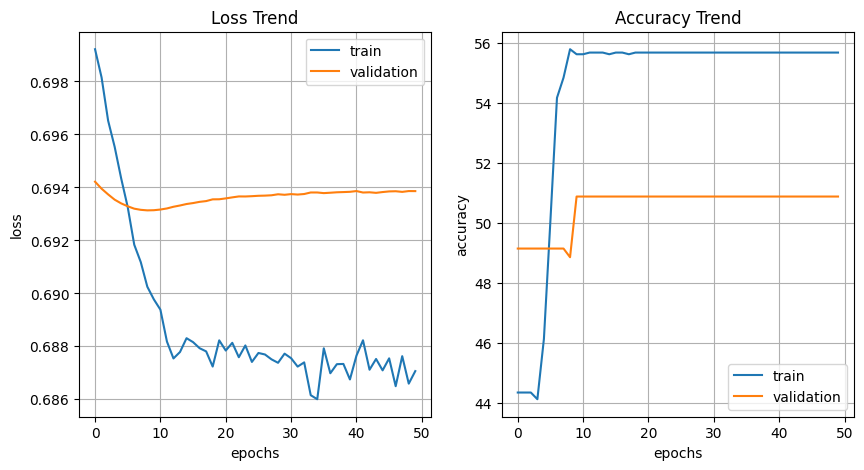

In [21]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.plot(train_accuracy_list, label='train')
plt.plot(val_accuracy_list, label='validation')
plt.legend()

plt.show()